# Classical Localization: Multilateration + Triangulation

In [1]:
from dichasus_cf0x import training_set, spec
import multiprocessing as mp
import tensorflow as tf
import numpy as np
import scipy
import tqdm

2023-10-23 07:23:16.439175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 07:23:17.194816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-23 07:23:18.056384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 07:23:18.079754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
# We assume that the z coordinate of the transmit antenna is fixed and known
groundtruth_positions = []
for csi, pos, time in training_set:
    groundtruth_positions.append(pos.numpy())

groundtruth_positions = np.asarray(groundtruth_positions)

HEIGHT = np.mean(groundtruth_positions[:,2])

# Count number of datapoints in training set (for progress bar)
TOTAL_DATAPOINTS = len(groundtruth_positions)

In [3]:
estimated_aoas = np.load("results/estimated_aoas.npy")
estimated_toas = np.load("results/estimated_toas.npy")
delayspreads = np.load("results/delayspreads.npy")

In [4]:
assert(len(estimated_aoas) == TOTAL_DATAPOINTS)
assert(len(estimated_toas) == TOTAL_DATAPOINTS)
assert(len(delayspreads) == TOTAL_DATAPOINTS)

In [5]:
SPEED_OF_LIGHT = 299792458
BANDWIDTH = 50e6
MEAN_TOA = np.mean(estimated_toas)

In [6]:
# These are some empirically determined heuristics, may be further tweaked
def get_aoa_vonmises_kappas(delayspreads):
    return 0.0000003 / (delayspreads + 0.025e-7)

def get_toa_variances(delayspreads):
    return 1 + (delayspreads * 1e7) ** 4

In [7]:
# Can generate either a TDoA-based or a ToA-based likelihood function.
# * If likelihood function is TDoA-based, then function parameters are location estimates (x, y, z)
# * If likelihood function is ToA-based, then function parameters are location + time offset estimates (x, y, z, t_off)
def get_likelihood_function(aoa_datapoint, toa_datapoint, rms_delay_spreads, differential_time = False):
    def likelihood_func(parameters):
        # "relative" has shape (number of positions, number of arrays, 3 spatial dimensions)
        relative_pos = parameters[:,np.newaxis,:3] - array_positions

        # Compute ideal 2D AoAs at given positions, shape: (number of positions, number of arrays)
        ideal_aoas = np.arctan2(-relative_pos[:, :, 1], -relative_pos[:, :, 0]) - np.arctan2(-array_normalvectors[:, 1], -array_normalvectors[:, 0])

        # Compute ideal TDoAs at given positions, shape: (number of positions, number of arrays)
        ideal_toas = np.sqrt(np.sum(np.square(relative_pos), axis = -1)) / SPEED_OF_LIGHT * BANDWIDTH

        # Compute AoA likelihoods based on von Mises distribution
        kappa = get_aoa_vonmises_kappas(rms_delay_spreads)
        aoa_likelihoods = np.exp(kappa * np.cos(ideal_aoas - aoa_datapoint)) / (2 * np.pi * np.i0(kappa))

        if differential_time:
            # Compute TDoA likelihoods based on Gaussian distribution. tdoa_difference has shape (number of positions, number of array-pairs)
            arraysA, arraysB = np.triu_indices(len(toa_datapoint), k = 1)
            estimated_tdoas = toa_datapoint[arraysB] - toa_datapoint[arraysA]
            ideal_tdoas = ideal_toas[:,arraysB] - ideal_toas[:,arraysA]
            tdoa_difference = ideal_tdoas - estimated_tdoas
            variances = get_toa_variances(np.maximum(rms_delay_spreads[arraysA], rms_delay_spreads[arraysB]))
            toa_likelihoods = np.einsum("a,pa->pa", np.divide(1, np.sqrt(2 * np.pi * variances)), np.exp(-0.5 * np.divide(np.square(tdoa_difference), variances)))
        else:
            # Compute ToA likelihoods based on Gaussian distribution. toa_differences has shape (number of positions, number of arrays)
            toa_differences = ideal_toas - toa_datapoint + parameters[:,3][:,np.newaxis]
            variances = get_toa_variances(rms_delay_spreads)
            toa_likelihoods = np.einsum("a,pa->pa", np.divide(1, np.sqrt(2 * np.pi * variances)), np.exp(-0.5 * np.divide(np.square(toa_differences), variances)))

        return np.multiply(np.product(aoa_likelihoods, axis = -1), np.product(toa_likelihoods, axis = -1))

    return likelihood_func

In [8]:
# Retrieve antenna array positions and normal vectors
array_positions = np.zeros((len(spec["antennas"]), 3))
array_normalvectors = np.zeros((len(spec["antennas"]), 3))

for antidx, antenna in enumerate(spec["antennas"]):
    array_positions[antidx] = np.asarray(antenna["location"])
    array_normalvectors[antidx] = np.asarray(antenna["direction"])

In [9]:
# Generate grid of potential TX positions, used for initializing optimization algorithm
candidate_xrange = np.linspace(np.min(array_positions[:,0]) - 5, np.max(array_positions[:,0]) + 5, 100)
candidate_yrange = np.linspace(np.min(array_positions[:,1]) - 5, np.max(array_positions[:,1]) + 5, 100)
candidate_initial_positions = np.transpose(np.meshgrid(candidate_xrange, candidate_yrange, HEIGHT)).reshape(-1, 3)

In [10]:
def toa_aoa_estimation_worker(todo_queue, output_queue):
    def estimate_position_aoa_toa(index):
        aoa_datapoint = estimated_aoas[index]
        toa_datapoint = estimated_toas[index]
        ds_datapoint = delayspreads[index]

        # We use the TDoA-based likelihood function to get a rough initial estimate, then the ToA-based likelihood function for optimization
        tdoa_likelihood_func = get_likelihood_function(aoa_datapoint, toa_datapoint, ds_datapoint, differential_time = True)
        toa_likelihood_func = get_likelihood_function(aoa_datapoint, toa_datapoint, ds_datapoint, differential_time = False)
    
        # Find most likely initialization position based on AoA + TDoA
        initial_point = candidate_initial_positions[np.argmax(tdoa_likelihood_func(candidate_initial_positions))]

        # Use scipy.optimize to find most likely TX position
        init_value = np.asarray([initial_point[0], initial_point[1], MEAN_TOA])
        optimize_res = scipy.optimize.minimize(lambda pos_and_time : -toa_likelihood_func(np.asarray([[pos_and_time[0], pos_and_time[1], HEIGHT, pos_and_time[2]]])), init_value, options = {"gtol": 1e-7})

        return np.asarray([optimize_res.x[0], optimize_res.x[1]]), -optimize_res.fun
    
    while True:
        index = todo_queue.get()

        if index == -1:
            output_queue.put((-1, None, None))
            break

        position, likelihood = estimate_position_aoa_toa(index)
        output_queue.put((index, position, likelihood))

In [11]:
todo_queue = mp.Queue()
output_queue = mp.Queue()

for i in zip(range(TOTAL_DATAPOINTS)):
    todo_queue.put(i)

for i in range(mp.cpu_count()):
    todo_queue.put(-1)
    p = mp.Process(target = toa_aoa_estimation_worker, args = (todo_queue, output_queue))
    p.start()

estimated_positions = np.zeros((TOTAL_DATAPOINTS, 2))

with tqdm.tqdm(total = TOTAL_DATAPOINTS) as bar:
    finished_processes = 0
    while finished_processes != mp.cpu_count():
        i, pos, lik = output_queue.get()

        if i == -1:
            finished_processes = finished_processes + 1
        else:
            estimated_positions[i,:] = pos
            bar.update(1)

100%|██████████| 20997/20997 [01:40<00:00, 209.43it/s]


In [12]:
np.save("results/estimated_positions.npy", estimated_positions)

### Optional: Evaluate accuracy of estimates

In [13]:
import matplotlib.pyplot as plt

In [14]:
def plot_colorized(positions, groundtruth_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(6, 6))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    plt.xlim((np.min(groundtruth_positions[:,0]) - 5, np.max(groundtruth_positions[:,0]) + 5))
    plt.ylim((np.min(groundtruth_positions[:,1]) - 5, np.max(groundtruth_positions[:,1]) + 5))
    if show:
        plt.show()

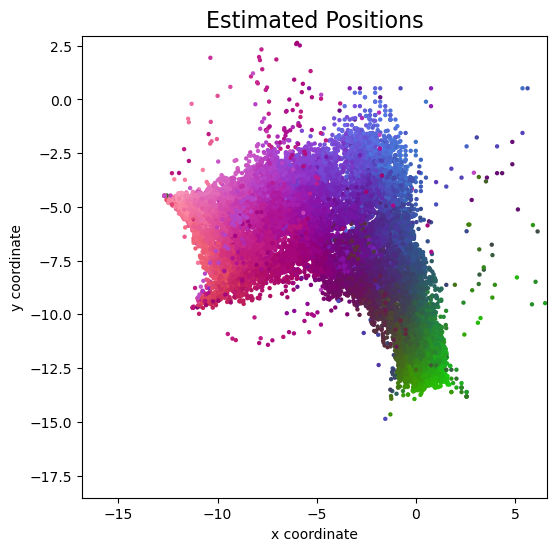

In [15]:
plot_colorized(estimated_positions[:,:2], groundtruth_positions[:,:2], title="Estimated Positions")

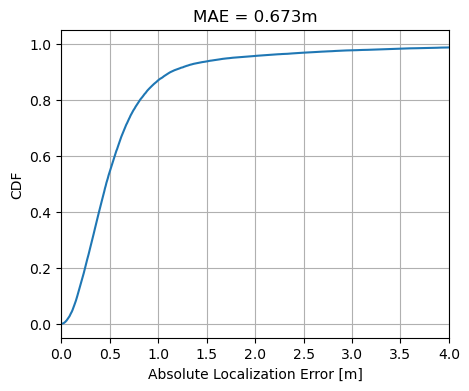

In [16]:
position_errors = estimated_positions[:,:2] - groundtruth_positions[:len(estimated_positions),:2]
absolute_errors = np.sqrt(np.sum(np.square(position_errors), axis = 1))

count, bins_count = np.histogram(absolute_errors, bins=5000)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

bins_count[0] = 0
cdf = np.append([0], cdf)

plt.figure(figsize=(5, 4))
plt.title("MAE = " + f"{(np.mean(absolute_errors)):.3f}m")
plt.plot(bins_count, cdf)
plt.xlim((0, 4))
plt.xlabel("Absolute Localization Error [m]")
plt.ylabel("CDF")
plt.grid()
plt.show()